In [64]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
sns.set_theme(style="darkgrid")
pd.set_option('display.max_columns', 0)
plt.style.use('ggplot')
pd.options.display.float_format = '{:.2f}'.format
import math
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.tree import DecisionTreeClassifier
from IPython.display import Image  
from six import StringIO
from sklearn.tree import export_graphviz
import graphviz
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
import random
import gzip
import category_encoders as ce
pd.options.display.float_format = '{:.2f}'.format

In [65]:
data = pd.read_csv('data.csv')
data.head()

,click,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,month,dayofweek,day,hour,y
0,False,1005,1,856e6d3f,58a89a43,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,962c8333,be6db1d7,1,0,22683,320,50,2528,0,39,100075,221,10,1,28,14,0
1,True,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,5b1f94b9,1b13b020,1,0,17037,320,50,1934,2,39,-1,16,10,2,22,19,1
2,False,1005,0,e3c09f3a,d262cf1e,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,a9a84f4c,9a45a8e8,1,0,22155,320,50,2552,3,167,100202,23,10,3,23,18,0
3,False,1002,0,0da94452,248e439f,50e219e0,ecad2386,7801e8d9,07d7df22,0fa578fd,88c62dad,ea6abc60,0,0,21591,320,50,2478,3,167,100074,23,10,2,22,19,0
4,True,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,1e5e0d0e,36d749e5,1,0,15708,320,50,1722,0,35,-1,79,10,1,21,8,1


In [66]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   click             99999 non-null  bool  
 1   C1                99999 non-null  int64 
 2   banner_pos        99999 non-null  int64 
 3   site_id           99999 non-null  object
 4   site_domain       99999 non-null  object
 5   site_category     99999 non-null  object
 6   app_id            99999 non-null  object
 7   app_domain        99999 non-null  object
 8   app_category      99999 non-null  object
 9   device_id         99999 non-null  object
 10  device_ip         99999 non-null  object
 11  device_model      99999 non-null  object
 12  device_type       99999 non-null  int64 
 13  device_conn_type  99999 non-null  int64 
 14  C14               99999 non-null  int64 
 15  C15               99999 non-null  int64 
 16  C16               99999 non-null  int64 
 17  C17         

In [67]:
data.isnull().sum()

click               0
C1                  0
banner_pos          0
site_id             0
site_domain         0
site_category       0
app_id              0
app_domain          0
app_category        0
device_id           0
device_ip           0
device_model        0
device_type         0
device_conn_type    0
C14                 0
C15                 0
C16                 0
C17                 0
C18                 0
C19                 0
C20                 0
C21                 0
month               0
dayofweek           0
day                 0
hour                0
y                   0
dtype: int64

In [68]:
# looks like following columns have outliers  C15, C16, C19, C21. 

data.describe()

,C1,banner_pos,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,month,dayofweek,day,hour,y
count,99999.00,99999.00,99999.00,99999.00,99999.00,99999.00,99999.00,99999.00,99999.00,99999.00,99999.00,99999.00,99999.00,99999.00,99999.00,99999.00,99999.00
mean,1004.97,0.29,1.02,0.33,18857.23,318.83,60.28,2114.61,1.44,227.23,53292.00,83.16,10.00,2.59,25.49,11.30,0.17
std,1.09,0.51,0.53,0.85,4944.92,21.51,47.71,607.47,1.33,351.47,49952.34,70.16,0.00,1.72,2.97,5.94,0.38
min,1001.00,0.00,0.00,0.00,375.00,120.00,20.00,112.00,0.00,33.00,-1.00,1.00,10.00,0.00,21.00,0.00,0.00
25%,1005.00,0.00,1.00,0.00,16920.00,320.00,50.00,1863.00,0.00,35.00,-1.00,23.00,10.00,1.00,23.00,7.00,0.00
50%,1005.00,0.00,1.00,0.00,20346.00,320.00,50.00,2323.00,2.00,39.00,100050.00,61.00,10.00,2.00,26.00,11.00,0.00
75%,1005.00,1.00,1.00,0.00,21893.00,320.00,50.00,2526.00,3.00,171.00,100093.00,101.00,10.00,4.00,28.00,16.00,0.00
max,1012.00,7.00,5.00,5.00,24043.00,1024.00,1024.00,2757.00,3.00,1839.00,100248.00,255.00,10.00,6.00,30.00,23.00,1.00


In [69]:
# Dealing with outliers by capping

col = ['C15', 'C16', 'C19', 'C21']
for col in col:
    percentiles = data[col].quantile(0.98)
    if data[col].quantile(0.98) < 0.5 * data[col].max():
        data[col][data[col] >= percentiles] = percentiles


False   0.83
True    0.17
Name: click, dtype: float64




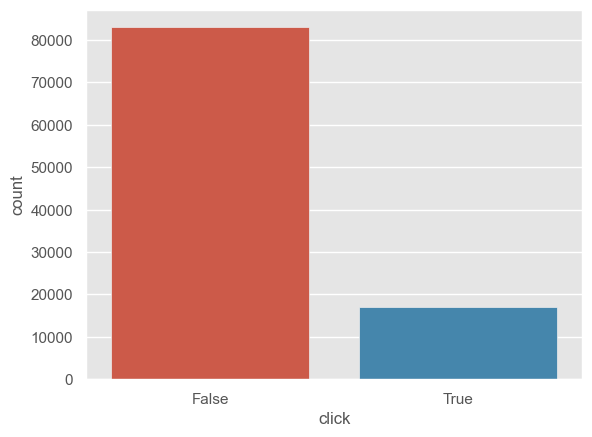

In [70]:


# y is the target variable, analysing the same.
# 83% values are 0 and 17% values are 1. data is highly imbalance. 

print(data.click.value_counts(normalize = True))
print("\n")
plt.figure()
sns.countplot(x='click', data=data)
plt.show()



Text(0.5, 1.05, 'Pearson correlation of Features')

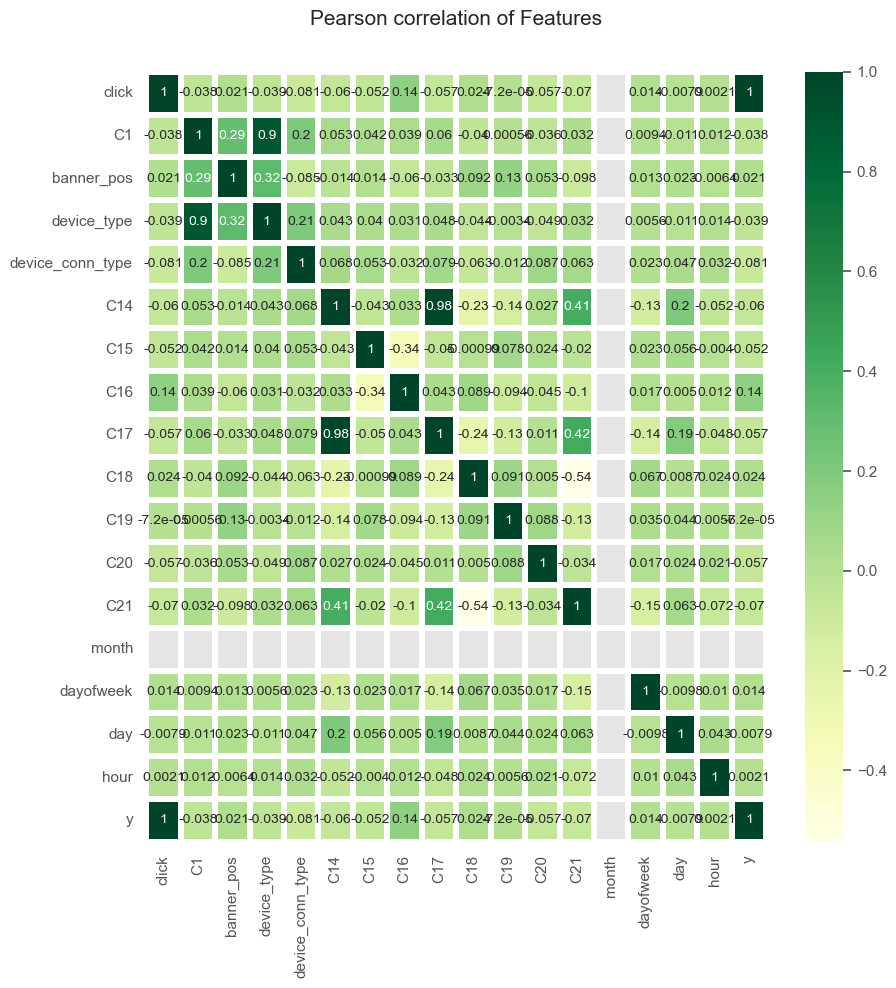

In [71]:

corr = train.corr()
f, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr, ax=ax, annot=True,linewidths=3,cmap='YlGn')
plt.title("Pearson correlation of Features", y=1.05, size=15)


observation

    month has got no significance, better to drop it
    y and click are same drop click column
    C14 and C17 are highly co-related, later will remove one of them after the base model.
    device type with C1 are highly co-related, later will remove one of them after the base model.
    Removing C20 anomalised column, since it have got nearly 47% of values with -1. As a categorical variable it's not expected to have values as -1.



In [72]:


# as said above dropping columns. 

data.drop(['month', 'C20'], axis=1, inplace=True)
data.columns



Index(['click', 'C1', 'banner_pos', 'site_id', 'site_domain', 'site_category',
       'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip',
       'device_model', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16',
       'C17', 'C18', 'C19', 'C21', 'dayofweek', 'day', 'hour', 'y'],
      dtype='object')

In [73]:
# dataset is huge and running multiple algo will take time and resources might exhaust, 
# hence taking only 10% of the data for analysis.

sampled_data = data.sample(frac=0.1, random_state=42)
X = sampled_data.drop(['y'], axis=1)
y = sampled_data['y']


0   0.83
1   0.17
Name: y, dtype: float64




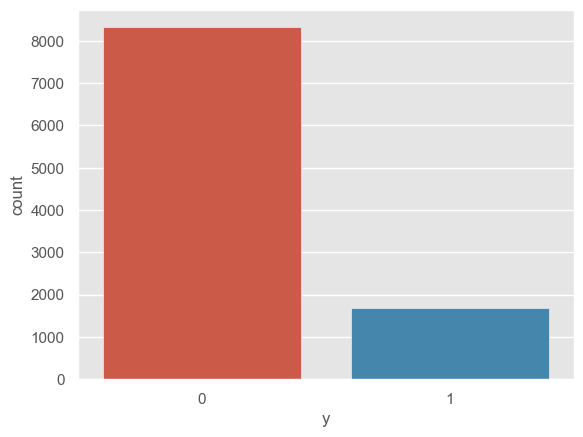

In [74]:


# After taking the sample of data, still the ratio of output remains same.

print(data.y.value_counts(normalize = True))
print("\n")
plt.figure()
sns.countplot(x=y)
plt.show()



In [75]:
target_encoder = ce.TargetEncoder()
X = target_encoder.fit_transform(X, y)
X.head(2)


,click,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C21,dayofweek,day,hour
26002,False,1005,0,0.12,0.13,0.13,0.06,0.06,0.11,0.17,0.17,0.20,1,0,21768,320,50,2506,0,35,157,2,22,12
80420,False,1005,1,0.31,0.26,0.17,0.19,0.19,0.19,0.17,0.17,0.19,1,0,20363,216,36,2333,0,39,157,2,22,14


In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size= 0.3, random_state= 42)

### Models without feature engineering

In [77]:
# this function helps in evaluation the given model and provide accuracy and confusion matrix. 

def model_eval(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    #print(accuracy)
    cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
    #print(cnf_matrix)
    #metrics.plot_confusion_matrix(model, X_test, y_test)
    #plt.show()
    return accuracy, cnf_matrix


In [78]:
# Plots the ROC curve and returns false positive rate, true positive rate, and thresholds. 

def draw_roc(model, Xtest, actual):
    probs = model.predict(X_test)
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(6, 6))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return fpr, tpr, thresholds

In [79]:
# Returns the ctossvalidation score for given number of n folds. 

def cross_val (model, x, y, folds):
    crossvalidation = cross_val_score(model, x, y, cv= folds, n_jobs=-1)
    return crossvalidation

In [80]:
# this stores the results in dataframe for evaluating the final result. 

def store_results(name, ytrain, xtrain, ytest, xtest, model, folds):
    
    crossvalidation = cross_val(model, xtrain, ytrain, folds)
    
    accuracy_test, cm1 =  model_eval(model, xtrain, ytrain)
    TP = cm1[1,1] # true positive 
    TN = cm1[0,0] # true negatives
    FP = cm1[0,1] # false positives
    FN = cm1[1,0] # false negatives
    recall_test = TP / (TP+FP)
    precision_test = TP / (TP+FN)
    
    accuracy_train, cm1 =  model_eval(model, xtest, ytest)
    TP = cm1[1,1] # true positive 
    TN = cm1[0,0] # true negatives
    FP = cm1[0,1] # false positives
    FN = cm1[1,0] # false negatives
    recall_train = TP / (TP+FP)
    precision_train = TP / (TP+FN)

    entry = {'Model': [name],
          'Accuracy_train': [accuracy_train],
          'recall_train': [recall_train],
          'precision_train': [precision_train],
          'Accuracy_test': [accuracy_train],
          'recall_test': [recall_train],
          'precision_test': [precision_train],
          'CrossVal_Mean': [crossvalidation.mean()],           
          'CrossVal1': [crossvalidation[0]],
          'CrossVal2': [crossvalidation[1]],
          'CrossVal3': [crossvalidation[2]],
          'CrossVal4': [crossvalidation[3]],
          'CrossVal5': [crossvalidation[4]],
          }
    result = pd.DataFrame(entry)
    return result


In [81]:
scaler = MinMaxScaler()
X_train[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])
X_train.head()


,click,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C21,dayofweek,day,hour
40590,0.00,0.36,0.14,0.13,0.14,0.23,0.20,0.25,0.39,0.26,0.22,0.17,0.20,0.00,0.91,1.00,0.13,0.91,0.00,0.07,0.87,0.33,0.89,0.43
98473,0.00,0.36,0.00,0.15,0.16,0.17,0.01,0.02,0.19,0.26,0.22,0.23,0.20,0.00,0.99,1.00,0.13,0.99,0.33,0.08,0.28,0.50,1.00,0.57
14902,1.00,0.36,0.14,0.32,0.32,0.23,0.20,0.25,0.39,0.26,0.53,0.29,0.20,0.00,0.73,1.00,0.13,0.71,0.67,0.57,0.13,0.83,0.44,0.78
66127,0.00,0.36,0.00,0.15,0.16,0.17,0.04,0.20,0.22,0.26,0.22,0.32,0.20,0.40,0.90,1.00,0.13,0.91,0.00,0.00,0.62,0.33,0.11,0.39
16990,0.00,0.36,0.00,0.20,0.21,0.02,0.20,0.25,0.39,0.26,0.22,0.06,0.20,0.00,0.97,1.00,0.13,0.97,0.33,0.00,0.84,0.17,0.78,0.61


In [82]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [83]:


X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])
X_test.head(2)



,click,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C21,dayofweek,day,hour
40690,1.00,0.36,0.14,0.13,0.16,0.38,0.20,0.25,0.39,0.26,0.22,0.53,0.20,0.00,0.82,1.00,0.13,0.80,0.00,0.36,0.19,1.00,0.56,0.35
25520,0.00,0.36,0.14,0.38,0.33,0.23,0.20,0.25,0.39,0.26,0.22,0.34,0.20,0.00,0.18,1.00,0.13,0.12,0.67,0.00,0.12,1.00,0.56,0.48


In [84]:
outcome = pd.DataFrame()
y_pred = model.predict(X_test)
accuracy, cnf_matrix = model_eval(model, X_test, y_test)
print(accuracy)
print(cnf_matrix)
temp = store_results("logistic regres - imbalance predict", y_train, X_train, y_test, X_test, model, 5)
outcome = outcome.append(temp)
outcome

1.0
[[2496    0]
 [   0  504]]


,Model,Accuracy_train,recall_train,precision_train,Accuracy_test,recall_test,precision_test,CrossVal_Mean,CrossVal1,CrossVal2,CrossVal3,CrossVal4,CrossVal5
0,logistic regres - imbalance predict,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


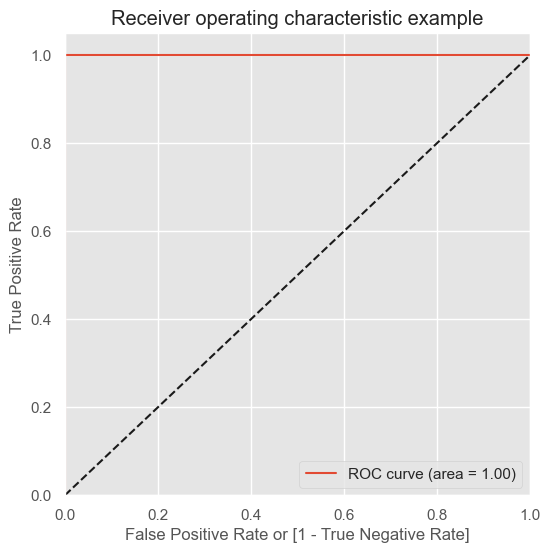

(array([0., 0., 1.]), array([0., 1., 1.]), array([2, 1, 0]))

In [85]:
draw_roc(model, X_test, y_test)

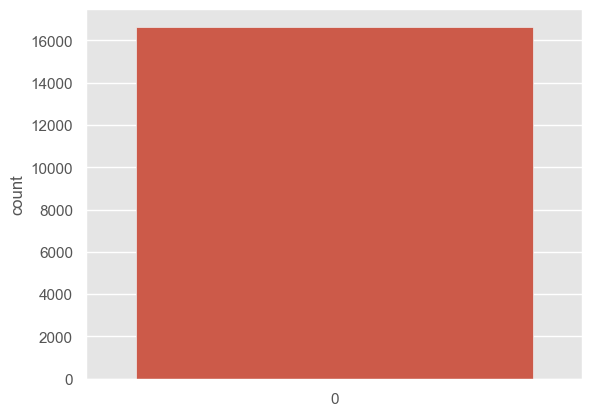

In [86]:


# x_new and y_new we will use for balanced data set for all modules
randomsample=  RandomOverSampler()
x_new, y_new = randomsample.fit_resample(X, y)


sns.countplot(y_new)
plt.show()



In [62]:
y_new.unique()

array([0, 1])

In [52]:


x_new.head(2)



,click,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C21,dayofweek,day,hour
0,False,1005,0,0.12,0.13,0.13,0.06,0.06,0.11,0.17,0.17,0.20,1,0,21768,320,50,2506,0,35,157,2,22,12
1,False,1005,1,0.31,0.26,0.17,0.19,0.19,0.19,0.17,0.17,0.19,1,0,20363,216,36,2333,0,39,157,2,22,14


In [53]:
X_train, X_test, y_train, y_test = train_test_split(x_new, y_new, stratify= y_new, test_size= 0.3, random_state= 42)

In [54]:


scaler = MinMaxScaler()
X_train[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])
X_train.head(2)



,click,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C21,dayofweek,day,hour
14854,1.00,0.36,0.00,0.15,0.16,0.17,0.18,0.22,0.22,0.25,0.22,0.25,0.20,0.00,0.18,1.00,0.13,0.12,0.67,0.00,0.12,0.33,0.89,0.61
10129,1.00,0.36,0.00,0.15,0.16,0.17,0.21,0.26,0.19,0.25,0.22,0.30,0.20,0.00,0.69,1.00,0.13,0.66,1.00,0.00,0.09,0.00,0.67,0.26


In [55]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

1.0
[[2496    0]
 [   0 2496]]


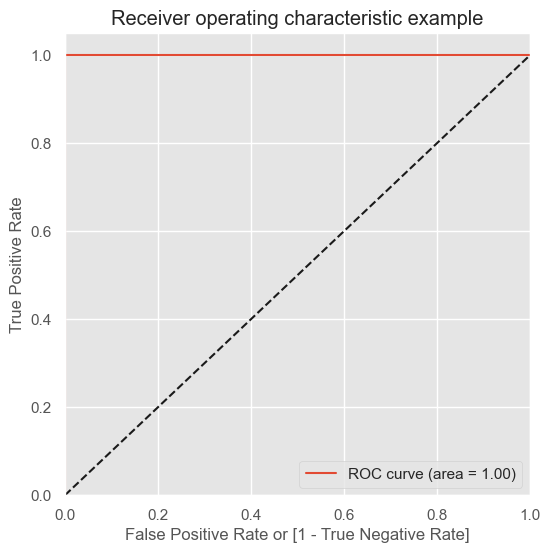

,Model,Accuracy_train,recall_train,precision_train,Accuracy_test,recall_test,precision_test,CrossVal_Mean,CrossVal1,CrossVal2,CrossVal3,CrossVal4,CrossVal5
0,logistic regres - imbalance predict,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
0,logistic regres - balance predict,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [56]:
X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])
y_pred = model.predict(X_test)
accuracy, cnf_matrix = model_eval(model, X_test, y_test)
print(accuracy)
print(cnf_matrix)
temp = store_results("logistic regres - balance predict", y_train, X_train, y_test, X_test, model, 5)
draw_roc(model, X_test, y_test)
outcome = outcome.append(temp)
outcome